In [ ]:
'''
1. 필요한거 설치
2. MP Holistic을 사용해 keypoints를 인식 (이미지 1개만)
3. keypoints 추출 및 저장 (pose, lh, rh, lh_a, rh_a) (이미지 1개만)
4. 폴더 생성
5. 데이터셋 생성
6. 라벨 생성 (지도 학습)
7. 모델 생성 및 LSTM 학습, tensorboard
8. 테스트 데이터로 예측
9. 가중치 저장
10. 혼동 행렬
11. 실제로 테스트
출처: https://www.youtube.com/watch?v=doDUihpj6ro&t=7803s
'''

# 1. Import and Install Dependencies

In [4]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
%pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python mediapipe sklearn matplotlib

  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
     -------------------------------------- 438.0/438.0 MB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 17.3 MB/s eta 0:00:00
     -------------------------------------- 462.5/462.5 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.0
    Uninstalling tensorflow-2.10.0:
      Successfully uninstalled tensorflow-2.10.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [17]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# mp_holistic (holistic=전체론의)
# detect되는 key points 전체를 받을 모델을 정의
# mp_drawing
# 모델에 저장된 key points를 화면에 그려줄 util

In [18]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# image = frame, model = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)로 생성된 모델
#     image를 RGB로 변환
#     model로 keypoints 추출 후 results에 저장
#     image를 BGR로 변환
#     image, results 리턴


In [4]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

# image = frame, results = detected key points
#     mp_drawing에 있는 draw_landmarks 함수를 사용해라
#     image에 그려라
#     results에 있는 pose_landmarks 속성을 (results에 얼굴, 왼손, 오른손, 자세 key points 집합이 각각 들어있음)
#     mp_holistic.POSE_CONNECTIONS 방식에 따라서 (1번 점을 몇번 점에 연결할지 집합에 따라 다름)

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

# image = frame, results = detected key points
#     똑같이 그리되 점과 연결선의 색깔과 크기를 바꿀 수 있음

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
# 0번 웹캠을 사용
# confidence가 0.5인 holistic model을 사용
#     웹캠이 열려있다면
#         영상을 읽는다 (ret=성공/실패, frame=프레임)

#         frame마다 holistic 모델을 사용하여 key points를 detect 후 (image = frame), (results = detected keypoints) 반환

#         image(frame)에 detected keypoints를 사용자 정의로 그리기

#         화면에 출력

#         10ms마다 화면 갱신, 그리고 'q' 입력시 종료
#     웹캠 자원 반환
#     모든 윈도우창 종료
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
print(results.left_hand_landmarks)
len(results.left_hand_landmarks.landmark)

# detected keypoints 확인
# detected keypoints len 확인

landmark {
  x: 0.8602839112281799
  y: 0.9278613328933716
  z: 2.5091895849982393e-07
}
landmark {
  x: 0.7761351466178894
  y: 0.8967322707176208
  z: -0.020956723019480705
}
landmark {
  x: 0.7107013463973999
  y: 0.8177120685577393
  z: -0.030056361109018326
}
landmark {
  x: 0.6706119179725647
  y: 0.7476086616516113
  z: -0.039569396525621414
}
landmark {
  x: 0.6299841403961182
  y: 0.694597065448761
  z: -0.04858209192752838
}
landmark {
  x: 0.7488560080528259
  y: 0.6625375747680664
  z: -0.0016533146845176816
}
landmark {
  x: 0.7123838663101196
  y: 0.5657768249511719
  z: -0.02005506493151188
}
landmark {
  x: 0.686383843421936
  y: 0.5110954642295837
  z: -0.039375171065330505
}
landmark {
  x: 0.6624124050140381
  y: 0.4600728750228882
  z: -0.054984524846076965
}
landmark {
  x: 0.7939246892929077
  y: 0.6412904262542725
  z: -0.010416300967335701
}
landmark {
  x: 0.7648999094963074
  y: 0.5280258655548096
  z: -0.02556362934410572
}
landmark {
  x: 0.7434613108634949


'\ndetected keypoints 확인\ndetected keypoints len 확인\n'

In [14]:
results

# results는 mediapipe.python.solution_base.SolutionOutputs 객체로 반환됨
# (results 안에 results.pose_landmarks 속성들이 있는 거임)

'\nresults는 mediapipe.python.solution_base.SolutionOutputs 객체로 반환됨\n(results 안에 results.pose_landmarks 속성들이 있는 거임)\n'

In [15]:
draw_landmarks(frame, results)

# 기본 색상으로 frame에 detected keypoints 그리기

'\n기본 색상으로 frame에 detected keypoints 그리기\n'

'\n그려진 frame을 RGB로 변환해서 출력\n'

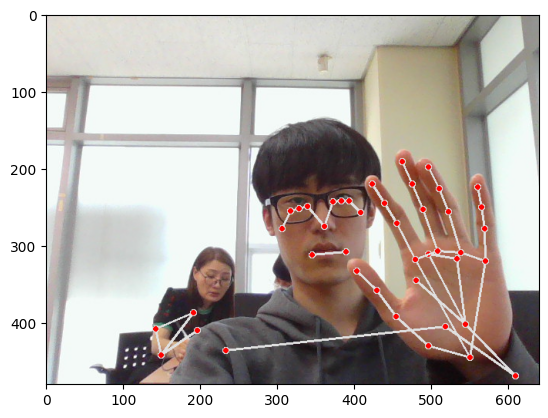

In [16]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 그려진 frame을 RGB로 변환해서 출력

# 3. Extract Keypoint Values

In [13]:
len(results.left_hand_landmarks.landmark)

# results 안에 있는 left_hand landmark 개수 확인

'\nresults 안에 있는 left_hand landmark 개수 확인\n'

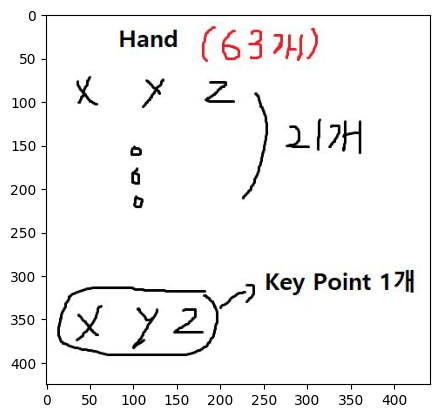

In [22]:
import matplotlib.image as img

hand_shape = img.imread('./img/hand_shape.jpg')
plt.imshow(hand_shape)
plt.show()


In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

# pose는 특이하게 visibility 속성이 추가로 하나 더 있음
# x = x좌표
# y = y좌표
# z = 카메라와의 거리
# visibility = 해당 포즈_랜드마크에 정의된 것과 동일합니다. (pose 여서 같은 포즈인지 봐주는 그런 속성인듯?)

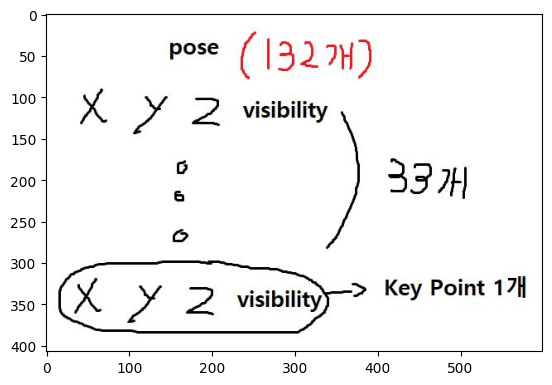

In [23]:
pose_shape = img.imread('./img/pose_shape.jpg')
plt.imshow(pose_shape)
plt.show()

In [24]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

# 함수 만들기 전에 확인용
# detect 된 landmarks가 있다면, landmarks를 flatten(1차원 배열)으로 만든다
# detect 된 landmarks가 없다면, np.zeros로 각 속성 shape에 맞는 zeros 배열 생성
# pose = 33행 4열 = 132
# face = 468행 3열 = 1404
# lh = 21행 3열 = 63
# rh = 21행 3열 = 63

In [38]:
def cal_angle(res):
    joint = np.zeros((21, 3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
    if res:
        for j, lm in enumerate(res.landmark):
            joint[j] = [lm.x, lm.y, lm.z] # 각 joint마다 x,y,z 좌표 저장
        # Compute angles between joints joint마다 각도 계산 
        # **공식문서 들어가보면 각 joint 번호의 인덱스가 나옴**
        # print('joint:',joint)
        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
        v = v2 - v1 # [20,3]관절벡터 
        # Normalize v
        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터 정규화(크기 1 벡터) = v / 벡터의 크기
        # print('v:',v)

        # Get angle using arcos of dot product **내적 후 arcos으로 각도를 구해줌** 
        angle = np.arccos(np.einsum('nt,nt->n',
            v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:], 
            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

        angle = np.degrees(angle) # Convert radian to degree
        # print('angle:',angle)

        # Inference gesture 학습시킨 제스처 모델에 참조를 한다. 
        # data = np.array([angle], dtype=np.float32)
        # print('data:',data)
        return angle
    else:
        return np.zeros((15, 1)).flatten()

# 손가락 각도 계산한 매개변수를 모델 학습에 사용하기 위해 추가한 함수
# res = results.left_hand_landmarks 또는 results.right_hand_landmarks
# 각각 각도를 계산한 후 배열로 반환
# angle.shape = (15,) = 1행 15열 

In [30]:
aaa = cal_angle(results.left_hand_landmarks)
bbb = results.left_hand_landmarks
# print('results:', bbb.landmark)
print(aaa.shape)
print(np.array([1,2,3,4,5]).shape)

# angle shape 확인용

(15,)
(5,)


In [44]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh_a = cal_angle(results.left_hand_landmarks)
    rh_a = cal_angle(results.right_hand_landmarks)
    # return np.concatenate([pose, face, lh, rh])
    # return np.concatenate([pose, face, lh, rh, lh_a, rh_a])
    return np.concatenate([pose, lh, rh, lh_a, rh_a])

# 각각 1차원으로 반환된 배열들을 합쳐서 반환 (288,)
# pose + lh + rh + lh_a + rh_a = 132 + 63 + 63 + 15 + 15 = 288
# 후에 이 배열을 LSTM 인공신경망 학습에 사용할 예정
# extract_keypoints(results)로 1프레임의 keypoints를 1차원 배열로 추출한거고 이걸 30번 반복해서 동작으로 학습시킴
# 1 frame에 1 배열 (288개)

In [40]:
aaa = extract_keypoints(results)
print(aaa.shape)

# extract_keypoints(results) shape 확인용

(288,)


In [43]:
print('pose',pose.shape, type(pose))
print('lh',lh.shape,type(lh))
print('rh',rh.shape,type(rh))
lh_a = cal_angle(results.left_hand_landmarks)
rh_a = cal_angle(results.right_hand_landmarks)
print('lh_a',lh_a.shape,type(lh_a))
print('lh_a',rh_a.shape,type(rh_a))

# 모든 배열 확인용

pose (132,) <class 'numpy.ndarray'>
lh (63,) <class 'numpy.ndarray'>
rh (63,) <class 'numpy.ndarray'>
lh_a (15,) <class 'numpy.ndarray'>
lh_a (15,) <class 'numpy.ndarray'>


In [ ]:
# joint = np.zeros((21, 3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
# for j, lm in enumerate(res.landmark):
#     joint[j] = [lm.x, lm.y, lm.z] # 각 joint마다 x,y,z 좌표 저장

# # Compute angles between joints joint마다 각도 계산 
# # **공식문서 들어가보면 각 joint 번호의 인덱스가 나옴**
# v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
# v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
# v = v2 - v1 # [20,3]관절벡터 
# # Normalize v
# v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터 정규화(크기 1 벡터) = v / 벡터의 크기

# # Get angle using arcos of dot product **내적 후 arcos으로 각도를 구해줌** 
# angle = np.arccos(np.einsum('nt,nt->n',
#     v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:], 
#     v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

# angle = np.degrees(angle) # Convert radian to degree

# # Inference gesture 학습시킨 제스처 모델에 참조를 한다. 
# data = np.array([angle], dtype=np.float32)
# ret, results, neighbours, dist = knn.findNearest(data, 3) # k가 3일 때 값을 구한다! 
# idx = int(results[0][0]) # 인덱스를 저장!

# 혜원님한테 받은 손가락 각도 계산하는 코드 원본

In [45]:
result_test = extract_keypoints(results)

In [46]:
result_test.shape

(288,)

In [47]:
33*4+21*3+21*3+15+15

288

In [51]:
np.save('0', result_test)

# np.save = 넘파이 배열을 저장하는 함수
# np.save('파일이름', 저장할 넘파이 배열)

In [52]:
np.load('0.npy')

# np.load = 넘파이 배열을 로드하는 함수
# np.load('로드할 파일 이름')

array([ 0.54491466,  0.57633948, -0.72666007, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [176]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data #aaa
no_sequences = 30
# no_sequences = 5

# Videos are going to be 30 frames in length
sequence_length = 30

# 작업 위치를 MP_Data 폴더로 한다
# 분류하려는 동작 3개 (hello, thanks, iloveyou)
# 학습에 사용할 데이터(비디오) 30개
# 비디오 1개의 프레임은 30

In [209]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 3번 반복 (hello, thanks, iloveyou)
# 30번 반복 (원하는 동영상 개수 30개)
# 없다면 MP_Data/hello/0 폴더를 만들고, 있다면 pass
# <결과>
# MP_Data
#     - hello
#         - 0
#         - 1
#         - ...
#         - 29
#     - thanks
#         - 0
#         - 1
#         - ...
#         - 29
#     -iloveyou
#         - 0
#         - 1
#         - ...
#         - 29
# 아직은 빈 폴더

# 5. Collect Keypoint Values for Training and Testing

In [210]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints #aaa
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

#     웹캡 0번 카메라 사용
#     신뢰도 0.5 holistic model 사용
#     3번 반복 (hello, thanks, iloveyou)
#         30번 반복 (동영상 30개)
#             30번 반복 (프레임 30개)
#                 성공, frame 반환
#                 1 frame, 1 frame의 keypoints 반환 (frame마다 keypoints detect)
#                 detected landmarks 그리기

#                 frame 시작한다면
#                     STARTING COLLECTION를 화면 중앙에 출력
#                     화면 위쪽에 Collecting frames for {action} Video Number {sequence} 출력
#                     frame 출력
#                     2초 가다림
#                 frame 중이라면
#                     화면 위쪽에 Collecting frames for {action} Video Number {sequence} 출력
#                     frame 출력

#                 현재 frame의 keypoints 추출
#                 MP_Data/hello/0/0번 프레임
#                 넘파이 배열 저장

#                 10ms마다 프레임 출력, 'q' 입력시 종료
# 웹캠 자원 반환
# 윈도우 창 전부 종료

In [158]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [211]:
label_map = {label:num for num, label in enumerate(actions)}

In [212]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [214]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [215]:
np.array(sequences).shape

(90, 30, 288)

In [216]:
np.array(labels).shape

(90,)

In [217]:
X = np.array(sequences)

In [218]:
X.shape

(90, 30, 288)

In [219]:
y = to_categorical(labels).astype(int)

In [220]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [222]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [223]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [224]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 288)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [225]:
res = [.7, 0.2, 0.1]

In [226]:
actions[np.argmax(res)]

'hello'

In [227]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [228]:
model.fit(X_train, y_train, epochs=90, callbacks=[tb_callback])
# tensorboard --logdir=.

Epoch 1/90
3/3 [==============================] - 3s 58ms/step - loss: 40.3580 - categorical_accuracy: 0.3765
Epoch 2/90
3/3 [==============================] - 0s 52ms/step - loss: 19.5162 - categorical_accuracy: 0.3765
Epoch 3/90
3/3 [==============================] - 0s 67ms/step - loss: 12.0448 - categorical_accuracy: 0.4941
Epoch 4/90
3/3 [==============================] - 0s 63ms/step - loss: 8.1204 - categorical_accuracy: 0.5059
Epoch 5/90
3/3 [==============================] - 0s 53ms/step - loss: 9.3915 - categorical_accuracy: 0.5176
Epoch 6/90
3/3 [==============================] - 0s 65ms/step - loss: 10.2844 - categorical_accuracy: 0.5059
Epoch 7/90
3/3 [==============================] - 0s 62ms/step - loss: 7.6876 - categorical_accuracy: 0.5294
Epoch 8/90
3/3 [==============================] - 0s 57ms/step - loss: 3.1255 - categorical_accuracy: 0.7529
Epoch 9/90
3/3 [==============================] - 0s 58ms/step - loss: 1.2316 - categorical_accuracy: 0.8000
Epoch 10/90
3/3

In [229]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 30, 64)            90368     
                                                                 
 lstm_29 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_30 (LSTM)              (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 3)                 99        
                                                                 
Total params: 244,931
Trainable params: 244,931
Non-t

# 8. Make Predictions

In [230]:
res = model.predict(X_test)

In [231]:
actions[np.argmax(res[0])]

'iloveyou'

In [232]:
actions[np.argmax(y_test[0])]

'iloveyou'

# 9. Save Weights

In [250]:
model.save('action.h5')

In [81]:
# del model

In [187]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [57]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [233]:
yhat = model.predict(X_test)

In [234]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [235]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [1, 0]],

       [[3, 1],
        [0, 1]],

       [[2, 0],
        [0, 3]]], dtype=int64)

In [236]:
accuracy_score(ytrue, yhat)

0.8

# 11. Test in Real Time

In [237]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [135]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [104]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [23]:
len(sequence)

1

In [51]:
sequence.append('def')

In [34]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [249]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [20]:
cap.release()
cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

True

In [ ]:
(num_sequences,30,1662)

In [240]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[5.532469e-04, 9.974770e-01, 1.969744e-03]], dtype=float32)